### The goal of this study is to reproduce the results of the paper “Semi-supervised Semantic Segmentation via Strong-weak Dual-branch Network".

### This file contains network definition, training and prediction functions for carrying out single branch experiments. There are two training functions, one for training with only strong data. 

# 1.Data Preparation Steps
## 1.1. Imports

In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library

# PyTorch libraries:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from typing import Any, Callable, Dict, Optional, Tuple, List
import os

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# fixing randon seeds
torch.manual_seed(501)
random.seed(501)
np.random.seed(501) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Import Colab Notebooks

In [ ]:
!cp /content/drive/MyDrive/Datasets.ipynb .
!pip install import-ipynb

import import_ipynb
import Datasets

#print(get_pascal_labels()[1])

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=2ee9d9344a5445eca9d20185ae38dc07b7f63e85f0cd5644ac29c9347c2c7cbf
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Datasets.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 31.2 MB 49 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.2 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1

In [ ]:
#!tar -xvf /content/drive/MyDrive/VOC_Strong.tar

## 1.3. Show Data 

In [ ]:
from Datasets import get_pascal_labels
from Datasets import VOCStrongDataset
from Datasets import SBDWeakDataset
from torch.utils.data import Dataset, DataLoader
from Datasets import decode_segmap

In [ ]:
!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/

VOC_strong_ds = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="train",img_size=328)
trainloader = DataLoader(VOC_strong_ds)

for i, d in enumerate(trainloader):
  if i < 1:
        inputs, targets = d
        #inputs, targets = inputs_.to(device), targets_.to(device)
        print(inputs.shape)
        #inputs = inputs.cpu()
        print(targets.shape)
        BS, _, _ = targets.shape
        for j in range(BS):
          plt.imshow(inputs[j][0])
          plt.show()
          nptargets = targets[j].numpy()
          print(nptargets.shape)
          decode_segmap(nptargets, plot=True)
         
print(i)

In [ ]:
#For SBD weak to see the data, if we can load the dataset properly

SBD_weak_ds = SBDWeakDataset(root='benchmark_RELEASE/', weak_path='/content/drive/MyDrive/SBDWeak/', is_transform=True, img_size=328, generate_pre_encoded=False)
trainloader2 = DataLoader(SBD_weak_ds)
for i, d in enumerate(trainloader2):
  if i < 1:
        inputs, targets = d
        #inputs, targets = inputs_.to(device), targets_.to(device)
        print(inputs.shape)
        #inputs = inputs.cpu()
        print(targets.shape)
        BS, _, _ = targets.shape
        for j in range(BS):
          plt.imshow(inputs[j][0])
          plt.show()
          nptargets = targets[j].numpy()
          print(nptargets.shape)
          decode_segmap(nptargets, plot=True)
          
print(i)

5622


#  2.Network Definition

In [ ]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
from torchvision import models

"""class SingleBranchNetwork(nn.Module):
    def __init__(self):
        super(SingleBranchNetwork, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)  
        backbone_tmp = models.resnet18(pretrained=True) 
        layers = list(backbone_tmp.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        self.neck = nn.Sequential(
            nn.Conv2d(512, 256,kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.Conv2d(256, 128,kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.Conv2d(128, 128,kernel_size=3,padding=1)#,
            #nn.ReLU()
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.neck[0].weight)
        torch.nn.init.xavier_uniform_(self.neck[1].weight)
        torch.nn.init.xavier_uniform_(self.neck[2].weight)
            
        self.branch = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=14, stride=2, padding=0),
            #nn.ReLU(),
            nn.Conv2d(128, 21, kernel_size=1)
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.branch[0].weight)
        torch.nn.init.xavier_uniform_(self.branch[1].weight)
        torch.nn.init.xavier_uniform_(self.branch[2].weight)
        torch.nn.init.xavier_uniform_(self.branch[3].weight)
        torch.nn.init.xavier_uniform_(self.branch[4].weight)
   
        
    def forward(self, x):
    
      x = self.backbone(x)
      x = self.neck(x)       
      x = self.branch(x)
  
      return x"""
class SingleBranchNetwork(nn.Module):
    def __init__(self):
        super(SingleBranchNetwork, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)  
        backbone_tmp = models.resnet18(pretrained=True) 
        layers = list(backbone_tmp.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        self.neck = nn.Sequential(
            nn.Conv2d(512, 256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128,kernel_size=3,padding=1),
            nn.ReLU()
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.neck[0].weight)
        torch.nn.init.xavier_uniform_(self.neck[3].weight)
        torch.nn.init.xavier_uniform_(self.neck[5].weight)
            
        self.branch = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=12, stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=14, stride=2, padding=0),
            #nn.ReLU(),
            nn.Conv2d(128, 21, kernel_size=1)
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.branch[0].weight)
        torch.nn.init.xavier_uniform_(self.branch[2].weight)
        torch.nn.init.xavier_uniform_(self.branch[3].weight)
        torch.nn.init.xavier_uniform_(self.branch[4].weight)
        torch.nn.init.xavier_uniform_(self.branch[5].weight)
   
        
    def forward(self, x):
    
      x = self.backbone(x)
      x = self.neck(x)       
      x = self.branch(x)
  
      return x

In [ ]:
def initialize_weights(m):
  #if isinstance(m, nn.Conv2d):
  torch.nn.init.xavier_uniform_(m.weight.data, gain=1.0)
  

batch_size = 16
model = SingleBranchNetwork()
#model.neck.apply(initialize_weights)
#model.branch.apply(initialize_weights)
print(summary(model, input_size=(batch_size, 3, 328, 328)))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Layer (type:depth-idx)                        Output Shape              Param #
SingleBranchNetwork                           --                        --
├─Sequential: 1-1                             [16, 512, 11, 11]         --
│    └─Conv2d: 2-1                            [16, 64, 164, 164]        9,408
│    └─BatchNorm2d: 2-2                       [16, 64, 164, 164]        128
│    └─ReLU: 2-3                              [16, 64, 164, 164]        --
│    └─MaxPool2d: 2-4                         [16, 64, 82, 82]          --
│    └─Sequential: 2-5                        [16, 64, 82, 82]          --
│    │    └─BasicBlock: 3-1                   [16, 64, 82, 82]          73,984
│    │    └─BasicBlock: 3-2                   [16, 64, 82, 82]          73,984
│    └─Sequential: 2-6                        [16, 128, 41, 41]         --
│    │    └─BasicBlock: 3-3                   [16, 128, 41, 41]         230,144
│    │    └─BasicBlock: 3-4                   [16, 128, 41, 41]         295,4

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 3.Training

###3.1. DataLoader 

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [ ]:
#we extract pre-encoded mask labels which we saved before in the drive, as here. These are mask labels for strong data and will be used as ground truth in the training 
!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/ 

import Datasets
from Datasets import VOCStrongDataset
from Datasets import SBDWeakDataset
from torch.utils.data import DataLoader

strong_dataset = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="train",img_size=328, generate_pre_encoded=False)
VOC_DataLoader = DataLoader(strong_dataset, batch_size)

###3.2. Training with Strong Data

In [ ]:
def train_strong(model, criterion, optimizer, scheduler, epochs, dataloader, verbose=True):

  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):   
      if (i % 10 == 0):
        print("Epoch:", epoch, "Iteration:", i)

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
  
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()
      scheduler.step()
      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    #Saving checkpoint after 5 epochs
    if ((epoch+1) % 5 == 0):
      print("End of epoch. Saving epoch data. Epoch:", epoch)
      state = {'epoch': epoch,
               'state_dict': model.state_dict(),
               'optimizer':  optimizer.state_dict(),
               'loss': loss}
             
      file_name = os.path.join('./SingleBranchStrongData/Training','checkpoint_epoch_{}'.format(epoch+1) + '.pt')
      torch.save(state, file_name)
    
  return loss_history

In [ ]:
# Preparation for training
!mkdir SingleBranchStrongData
!mkdir SingleBranchStrongData/Training

#!rm SingleBranchStrongData/Training/*

In [ ]:
epochs = 20
 # loss function
Centropyloss = torch.nn.CrossEntropyLoss()

# optimizer variable. In the paper authors stated that 'We use Adam optimizer [14] with an initial learning rate of 1e-4
# for the newly-added branches and 5e-6 for the backbone'
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr':5e-6},
                {'params': model.neck.parameters()},
                {'params': model.branch.parameters()}
            ], lr=1e-4, weight_decay=1e-4)

#schedular variable: In the paper authors stated that `The learning rate is decayed by a factor of ten after 12 epochs'
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)

loss_history = train_strong(model, Centropyloss, optimizer, scheduler, epochs, VOC_DataLoader, verbose=True)

Epoch: 0 Iteration: 0
Epoch: 0 Iteration: 10
Epoch: 0 Iteration: 20
Epoch: 0 Iteration: 30
Epoch: 0 Iteration: 40
Epoch: 0 Iteration: 50
Epoch: 0 Iteration: 60
Epoch: 0 Iteration: 70
Epoch: 0 Iteration: 80
Epoch: 0 Iteration: 90
Epoch 0 / 20: avg. loss of last 5 iterations 2.180247163772583
Epoch: 1 Iteration: 0
Epoch: 1 Iteration: 10
Epoch: 1 Iteration: 20
Epoch: 1 Iteration: 30
Epoch: 1 Iteration: 40
Epoch: 1 Iteration: 50
Epoch: 1 Iteration: 60
Epoch: 1 Iteration: 70
Epoch: 1 Iteration: 80
Epoch: 1 Iteration: 90
Epoch 1 / 20: avg. loss of last 5 iterations 1.8073694944381713
Epoch: 2 Iteration: 0
Epoch: 2 Iteration: 10
Epoch: 2 Iteration: 20
Epoch: 2 Iteration: 30
Epoch: 2 Iteration: 40
Epoch: 2 Iteration: 50
Epoch: 2 Iteration: 60
Epoch: 2 Iteration: 70
Epoch: 2 Iteration: 80
Epoch: 2 Iteration: 90
Epoch 2 / 20: avg. loss of last 5 iterations 1.4759164333343506
Epoch: 3 Iteration: 0
Epoch: 3 Iteration: 10
Epoch: 3 Iteration: 20
Epoch: 3 Iteration: 30
Epoch: 3 Iteration: 40
Epoch: 3

In [ ]:
#!rm SingleBranchStrongData/Training/*
#!ls -al SingleBranchStrongData/Training
!cp SingleBranchStrongData/Training/checkpoint_epoch_20.pt /content/drive/MyDrive/checkpoint__230721
#!cp SingleBranchStrongData/Training/checkpoint_epoch_15.pt /content/drive/MyDrive/

####3.2.1. Visualize the Loss Curve (Strong Data)

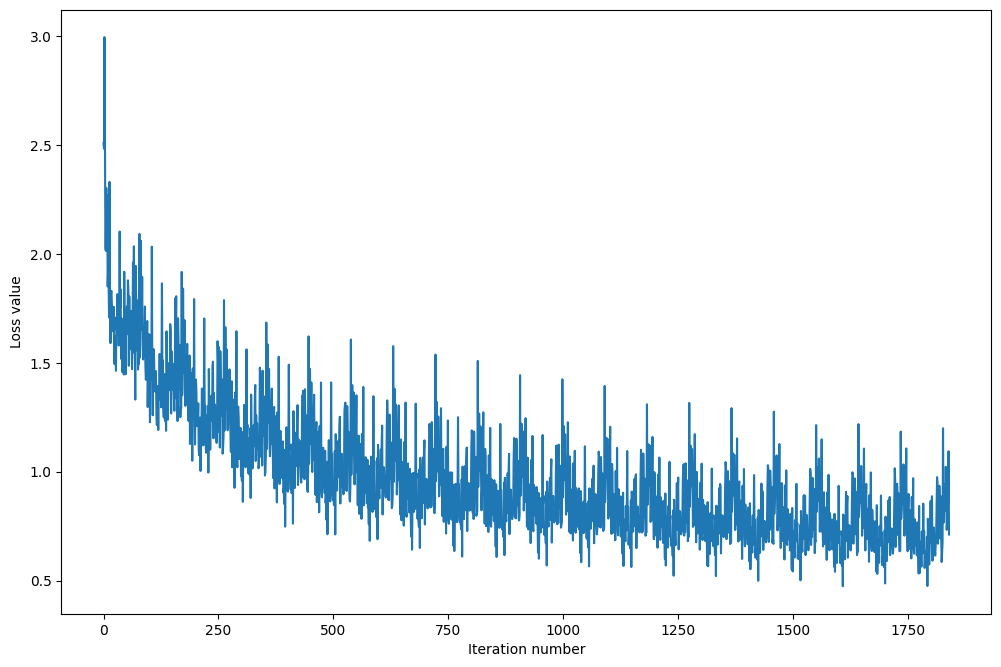

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

###3.3. Training with Strong and Weak Data

In [ ]:
def train_strong_weak(model, criterion, optimizer, scheduler, epochs, dataloader_strong, dataloader_weak, verbose=True):

  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader_strong, 0):   
      if (i % 10 == 0):
        print("Epoch:", epoch, "Strong Iteration:", i)

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
  
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()
      scheduler.step()
      loss_history.append(loss.item())

    for i, data in enumerate(dataloader_weak, 0):   
      if (i % 10 == 0):
        print("Epoch:", epoch, "Weak Iteration:", i)

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
  
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()
      scheduler.step()
      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    #Saving checkpoint after 5 epochs
    if ((epoch+1) % 5 == 0):
      print("End of epoch. Saving epoch data. Epoch:", epoch)
      state = {'epoch': epoch,
               'state_dict': model.state_dict(),
               'optimizer':  optimizer.state_dict(),
               'loss': loss}
             
      file_name = os.path.join('./SingleBranchStrongWeakData/Training','checkpoint_epoch_{}'.format(epoch+1) + '.pt')
      torch.save(state, file_name)
    
  return loss_history

In [ ]:
# Preparation for training
!mkdir SingleBranchStrongWeakData
!mkdir SingleBranchStrongWeakData/Training

#we extract pre-encoded mask labels which we saved before in the drive, as here. These are mask labels for strong data and will be used as ground truth in the training 
!tar -xvf /content/drive/MyDrive/SBDWeak-pre_encoded.tar benchmark_RELEASE/weak_pre_encoded/

#!rm SingleBranchStrongData/Training/*

Görüntülenen çıkış son 5000 satıra kısaltıldı.
benchmark_RELEASE/weak_pre_encoded/2008_000260.png
benchmark_RELEASE/weak_pre_encoded/2010_005949.png
benchmark_RELEASE/weak_pre_encoded/2009_002626.png
benchmark_RELEASE/weak_pre_encoded/2010_002193.png
benchmark_RELEASE/weak_pre_encoded/2010_001850.png
benchmark_RELEASE/weak_pre_encoded/2008_000941.png
benchmark_RELEASE/weak_pre_encoded/2010_003329.png
benchmark_RELEASE/weak_pre_encoded/2008_001880.png
benchmark_RELEASE/weak_pre_encoded/2008_006400.png
benchmark_RELEASE/weak_pre_encoded/2008_006606.png
benchmark_RELEASE/weak_pre_encoded/2010_002899.png
benchmark_RELEASE/weak_pre_encoded/2008_001402.png
benchmark_RELEASE/weak_pre_encoded/2008_003761.png
benchmark_RELEASE/weak_pre_encoded/2009_004829.png
benchmark_RELEASE/weak_pre_encoded/2010_000564.png
benchmark_RELEASE/weak_pre_encoded/2009_001807.png
benchmark_RELEASE/weak_pre_encoded/2011_002031.png
benchmark_RELEASE/weak_pre_encoded/2008_004770.png
benchmark_RELEASE/weak_pre_encoded/

In [ ]:
epochs = 20
 # loss function
Centropyloss = torch.nn.CrossEntropyLoss()

# optimizer variable. In the paper authors stated that 'We use Adam optimizer [14] with an initial learning rate of 1e-4
# for the newly-added branches and 5e-6 for the backbone'
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr':5e-6},
                {'params': model.neck.parameters()},
                {'params': model.branch.parameters()}
            ], lr=1e-4, weight_decay=1e-4)

#scheduler variable: In the paper authors stated that `The learning rate is decayed by a factor of ten after 12 epochs'
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)

sbd_dataset = SBDWeakDataset(root='benchmark_RELEASE/', weak_path='/content/drive/MyDrive/SBDWeak/', is_transform=True, img_size=328, generate_pre_encoded=False)
SBD_DataLoader = DataLoader(strong_dataset, batch_size)

loss_history = train_strong_weak(model, Centropyloss, optimizer, scheduler, epochs, VOC_DataLoader, SBD_DataLoader, verbose=True)

Epoch: 0 Strong Iteration: 0
Epoch: 0 Strong Iteration: 10
Epoch: 0 Strong Iteration: 20
Epoch: 0 Strong Iteration: 30
Epoch: 0 Strong Iteration: 40
Epoch: 0 Strong Iteration: 50
Epoch: 0 Strong Iteration: 60
Epoch: 0 Strong Iteration: 70
Epoch: 0 Strong Iteration: 80
Epoch: 0 Strong Iteration: 90
Epoch: 0 Weak Iteration: 0
Epoch: 0 Weak Iteration: 10
Epoch: 0 Weak Iteration: 20
Epoch: 0 Weak Iteration: 30
Epoch: 0 Weak Iteration: 40
Epoch: 0 Weak Iteration: 50
Epoch: 0 Weak Iteration: 60
Epoch: 0 Weak Iteration: 70
Epoch: 0 Weak Iteration: 80
Epoch: 0 Weak Iteration: 90
Epoch 0 / 20: avg. loss of last 5 iterations 1.8072476863861084
Epoch: 1 Strong Iteration: 0
Epoch: 1 Strong Iteration: 10
Epoch: 1 Strong Iteration: 20
Epoch: 1 Strong Iteration: 30
Epoch: 1 Strong Iteration: 40
Epoch: 1 Strong Iteration: 50
Epoch: 1 Strong Iteration: 60
Epoch: 1 Strong Iteration: 70
Epoch: 1 Strong Iteration: 80
Epoch: 1 Strong Iteration: 90
Epoch: 1 Weak Iteration: 0
Epoch: 1 Weak Iteration: 10
Epoc

In [ ]:
#!rm SingleBranchStrongData/Training/*
#!ls -al SingleBranchStrongData/Training
!cp SingleBranchStrongWeakData/Training/checkpoint_epoch_15.pt /content/drive/MyDrive/checkpoint_strongweak_epoch15_240721
!cp SingleBranchStrongWeakData/Training/checkpoint_epoch_20.pt /content/drive/MyDrive/checkpoint_strongweak_epoch20_240721
#!cp SingleBranchStrongData/Training/checkpoint_epoch_15.pt /content/drive/MyDrive/

####3.3.1 Visualize the Loss Curve

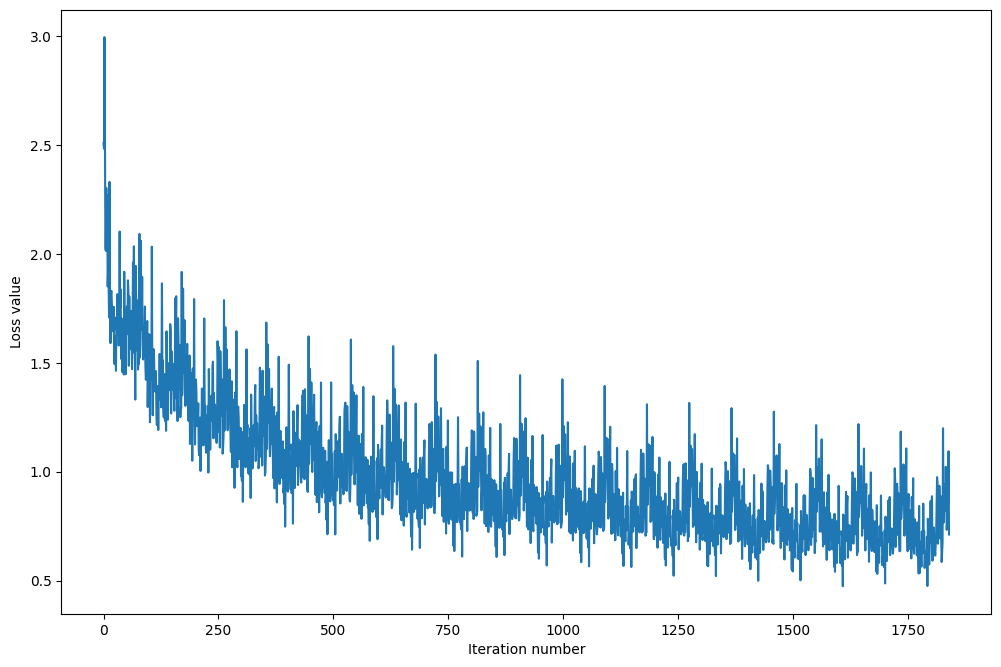

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

# 4.Predicting

###4.1. Loading Checkpoint

In [ ]:
!ls -al /content/drive/MyDrive/checkpoint_strongweak_epoch20_240721.pt

-rw------- 1 root root 277244187 Jul 24 11:27 /content/drive/MyDrive/checkpoint_strongweak_epoch20_240721.pt


In [ ]:
#!cp /content/drive/MyDrive/checkpoint__230721/checkpoint_epoch_20.pt .
!cp /content/drive/MyDrive/checkpoint_strongweak_epoch20_240721.pt .


In [ ]:
model= SingleBranchNetwork()
# optimizer variable. In the paper authors stated that 'We use Adam optimizer [14] with an initial learning rate of 1e-4
# for the newly-added branches and 5e-6 for the backbone'
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr':5e-6},
                {'params': model.neck.parameters()},
                {'params': model.branch.parameters()}
            ], lr=1e-4, weight_decay=1e-4)

#schedular variable: In the paper authors stated that `The learning rate is decayed by a factor of ten after 12 epochs'
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)
#checkpoint = torch.load('./checkpoint_epoch_20.pt')
checkpoint = torch.load('./checkpoint_strongweak_epoch20_240721.pt')
 
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# creating output directories
#!mkdir SingleBranchStrongData
#!mkdir SingleBranchStrongData/Results
#!mkdir SingleBranchStrongData/Results/pred

#!rm SingleBranchStrongData/Results/pred/*


!mkdir SingleBranchStrongWeakData
!mkdir SingleBranchStrongWeakData/Results
!mkdir SingleBranchStrongWeakData/Results/pred

###4.2. Predicting with Test Dataset

In [ ]:
#we extract pre-encoded mask labels which we saved before in the drive, as here. These are mask labels for strong data and will be used as ground truth in the training 
!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/ 

In [ ]:
batch_size = 16
from Datasets import decode_segmap

# Importing Image module from PIL package 
from PIL import Image 
import PIL

from os.path import join as pjoin

def predict(model, batch_size, output_path):
  strong_val_dataset = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="val",img_size=328, generate_pre_encoded=False)
  VOC_Test_DataLoader = DataLoader(strong_val_dataset, batch_size)

  correct = 0
  total = 0
  model.eval()
  np.set_printoptions(threshold=np.inf)
  model.to(device)
  with torch.no_grad():
      for i, data in enumerate(VOC_Test_DataLoader, 0):
        images, labels = data
        images = images.to(device)
        outputs = model(images)

        outputs1 = F.softmax(outputs, dim=1)
        outputs_argmax = torch.argmax(outputs1, dim=1)
        
        for j in range(outputs_argmax.shape[0]):
          pred_in = outputs_argmax[j].cpu().numpy()
          pred_arr = decode_segmap(pred_in, plot=False)      
          pred_image = Image.fromarray((pred_arr * 255).astype(np.uint8))
          image_name = strong_val_dataset.files[strong_val_dataset.split][i*batch_size + j]
          print('Saving ', image_name)
          image_path = pjoin(output_path, image_name + '_pred.png')
          pred_image.save(image_path)
          pred_image.show()

# strong data predict
#predict(model, batch_size, './SingleBranchStrongData/Results/pred')
predict(model, batch_size, './SingleBranchStrongWeakData/Results/pred')

Saving  2007_000033
Saving  2007_000042
Saving  2007_000061
Saving  2007_000123
Saving  2007_000129
Saving  2007_000175
Saving  2007_000187
Saving  2007_000323
Saving  2007_000332
Saving  2007_000346
Saving  2007_000452
Saving  2007_000464
Saving  2007_000491
Saving  2007_000529
Saving  2007_000559
Saving  2007_000572
Saving  2007_000629
Saving  2007_000636
Saving  2007_000661
Saving  2007_000663
Saving  2007_000676
Saving  2007_000727
Saving  2007_000762
Saving  2007_000783
Saving  2007_000799
Saving  2007_000804
Saving  2007_000830
Saving  2007_000837
Saving  2007_000847
Saving  2007_000862
Saving  2007_000925
Saving  2007_000999
Saving  2007_001154
Saving  2007_001175
Saving  2007_001239
Saving  2007_001284
Saving  2007_001288
Saving  2007_001289
Saving  2007_001299
Saving  2007_001311
Saving  2007_001321
Saving  2007_001377
Saving  2007_001408
Saving  2007_001423
Saving  2007_001430
Saving  2007_001457
Saving  2007_001458
Saving  2007_001526
Saving  2007_001568
Saving  2007_001585


In [ ]:
!tar -cvf SingleBranchStrongWeakData_pred.tar  SingleBranchStrongWeakData/Results/pred
#!ls -al SingleBranchStrongData_pred.tar
!cp SingleBranchStrongWeakData_pred.tar /content/drive/MyDrive/prediction_results_strongweak_2407/

SingleBranchStrongWeakData/Results/pred/
SingleBranchStrongWeakData/Results/pred/2008_005525_pred.png
SingleBranchStrongWeakData/Results/pred/2008_005904_pred.png
SingleBranchStrongWeakData/Results/pred/2009_003666_pred.png
SingleBranchStrongWeakData/Results/pred/2007_004281_pred.png
SingleBranchStrongWeakData/Results/pred/2008_004399_pred.png
SingleBranchStrongWeakData/Results/pred/2009_001505_pred.png
SingleBranchStrongWeakData/Results/pred/2008_001971_pred.png
SingleBranchStrongWeakData/Results/pred/2007_003349_pred.png
SingleBranchStrongWeakData/Results/pred/2011_001988_pred.png
SingleBranchStrongWeakData/Results/pred/2007_009221_pred.png
SingleBranchStrongWeakData/Results/pred/2010_000559_pred.png
SingleBranchStrongWeakData/Results/pred/2008_005399_pred.png
SingleBranchStrongWeakData/Results/pred/2007_007524_pred.png
SingleBranchStrongWeakData/Results/pred/2011_000438_pred.png
SingleBranchStrongWeakData/Results/pred/2008_002379_pred.png
SingleBranchStrongWeakData/Results/pred/2009

In [ ]:
!ls -al /content/drive/MyDrive/prediction_results_strongweak_2407

total 5000
-rw------- 1 root root 5120000 Jul 24 11:59 SingleBranchStrongWeakData_pred.tar
